In [1]:
import numpy as np
import os,sys
import subprocess as sp 

from pymatgen import MPRester
mpr = MPRester('AdhiVtzgaqU02rZT')  # here I put my API key to access MP
from pymatgen.core.periodic_table import Element

import shutil

from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline

from pylab import *
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from matplotlib import gridspec

%matplotlib inline

<span class="mark">Here I set runtime parameters</span>

In [2]:
mpid='mp-504'     # Materials Project id
ca='Cu'           # scattering ion symbol

rFMS=6.1          # FMS radius in FEFF calculation
rSCF=4.6          # SCF radius in FEFF calculation
corehole='RPA'    # core-hole treatment

nmax=80           # this will be used to determine inequivalent ions of structure
                  # 50-80 is usually enough.

#"This is for linux. On Windows, maybe you need to set this to feff.BAT in JEFF directory.    
feff_command='/home/mt/software/JFEFF/feff.sh > feff.out'

<span class="mark">Here I define functions</span>

In [3]:
# This searches structures in MP database.
# not used in this version.
def generate_mpid_list(search_pattern,nmax=None):
    
    if nmax is None: nmax=5
    
    found = []
    data = mpr.get_data(search_pattern, data_type="vasp", prop="nsites")
    for i in range(len(data)):
        if data[i]['nsites'] <= nmax: found.append(data[i]['material_id'])
        
    l = len(found)
    print("""Found %(l)i structures""" % vars())
    
    mpid_list = found 
    
    return mpid_list


# this gets POSCAR file from MP
def get_poscar(mpid):
    
    data = mpr.get_data(mpid, data_type="vasp")
    
    # if icsd_id is not available, this stucture 
    # might be artifical. So I get relaxed coordinates.
    if data[0]['icsd_ids']:
        structure = mpr.get_structure_by_material_id(mpid,final=False) # get initial coordinates ()
        structure.to(filename = "POSCAR")       
    else:
        structure = mpr.get_structure_by_material_id(mpid,final=True)
        structure.to(filename = "POSCAR")        
    return


# this reads POSCAR
def readposcar(file):
    
    lattice = []; positions_dir = []; labels = []
    
    with open(file, mode='r') as f:
        
        f.readline()
        f.readline()
        
        for i in range(3):
            l =  f.readline()
            l = l.split()
            l = [float(x) for x in l]
            lattice.append(l)
        lattice = np.array(lattice)
        
        f.readline()
        natoms = f.readline().split(); natoms = [int(x) for x in natoms]; natoms = np.array(natoms)
        mode = f.readline().split()
        
        labels = []
        for i in range(sum(natoms)):
            p = f.readline()
            l = p.split()[3]
            p = p.split()[0:3]
            p = [float(x) for x in p]
            positions_dir.append(p)
            labels.append(l)
                              
        positions = []; pnew = [] 
        for p in range(len(positions_dir)):
            pnew.append(positions_dir[p][0]*lattice[0][0]+positions_dir[p][1]*lattice[1][0] + positions_dir[p][2]*lattice[2][0] ); 
            pnew.append(positions_dir[p][0]*lattice[0][1]+positions_dir[p][1]*lattice[1][1] + positions_dir[p][2]*lattice[2][1] );
            pnew.append(positions_dir[p][0]*lattice[0][2]+positions_dir[p][1]*lattice[1][2] + positions_dir[p][2]*lattice[2][2] );
            positions.append(pnew); pnew = []   
        positions = np.array(positions) 
        positions = positions.reshape(len(positions),3,order='F').copy()

    return labels, natoms, lattice, positions, positions_dir


# this creates 3x3x3 supercell
def make_333_supercell(labels, natoms, lattice, positions):
    
    supercell = []; pnew=[]; p=positions; l=lattice; ls = []

    for s in range(len(p)):

        pnew.append(p[s][0]); pnew.append(p[s][1]); pnew.append(p[s][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[]

        pnew.append(p[s][0]+l[0][0]); pnew.append(p[s][1]+l[0][1]); pnew.append(p[s][2]+l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +x
        pnew.append(p[s][0]-l[0][0]); pnew.append(p[s][1]-l[0][1]); pnew.append(p[s][2]-l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -x
        pnew.append(p[s][0]+l[1][0]); pnew.append(p[s][1]+l[1][1]); pnew.append(p[s][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +y
        pnew.append(p[s][0]-l[1][0]); pnew.append(p[s][1]-l[1][1]); pnew.append(p[s][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -y
        pnew.append(p[s][0]+l[2][0]); pnew.append(p[s][1]+l[2][1]); pnew.append(p[s][2]+l[2][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z
        pnew.append(p[s][0]-l[2][0]); pnew.append(p[s][1]-l[2][1]); pnew.append(p[s][2]-l[2][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z

        pnew.append(p[s][0]+l[0][0]+l[1][0]); pnew.append(p[s][1]+l[0][1]+l[1][1]); pnew.append(p[s][2]+l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +x+y
        pnew.append(p[s][0]+l[0][0]-l[1][0]); pnew.append(p[s][1]+l[0][1]-l[1][1]); pnew.append(p[s][2]+l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +x-y
        pnew.append(p[s][0]-l[0][0]+l[1][0]); pnew.append(p[s][1]-l[0][1]+l[1][1]); pnew.append(p[s][2]-l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -x+y
        pnew.append(p[s][0]-l[0][0]-l[1][0]); pnew.append(p[s][1]-l[0][1]-l[1][1]); pnew.append(p[s][2]-l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -x-y
        pnew.append(p[s][0]+l[2][0]+l[0][0]); pnew.append(p[s][1]+l[2][1]+l[0][1]); pnew.append(p[s][2]+l[2][2]+l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z+x
        pnew.append(p[s][0]+l[2][0]-l[0][0]); pnew.append(p[s][1]+l[2][1]-l[0][1]); pnew.append(p[s][2]+l[2][2]-l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z-x
        pnew.append(p[s][0]-l[2][0]+l[0][0]); pnew.append(p[s][1]-l[2][1]+l[0][1]); pnew.append(p[s][2]-l[2][2]+l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z+x
        pnew.append(p[s][0]-l[2][0]-l[0][0]); pnew.append(p[s][1]-l[2][1]-l[0][1]); pnew.append(p[s][2]-l[2][2]-l[0][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z-x
        pnew.append(p[s][0]+l[2][0]+l[1][0]); pnew.append(p[s][1]+l[2][1]+l[1][1]); pnew.append(p[s][2]+l[2][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z+y
        pnew.append(p[s][0]+l[2][0]-l[1][0]); pnew.append(p[s][1]+l[2][1]-l[1][1]); pnew.append(p[s][2]+l[2][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z-y
        pnew.append(p[s][0]-l[2][0]+l[1][0]); pnew.append(p[s][1]-l[2][1]+l[1][1]); pnew.append(p[s][2]-l[2][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z+y
        pnew.append(p[s][0]-l[2][0]-l[1][0]); pnew.append(p[s][1]-l[2][1]-l[1][1]); pnew.append(p[s][2]-l[2][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z-y

        pnew.append(p[s][0]+l[2][0]+l[0][0]+l[1][0]); pnew.append(p[s][1]+l[2][1]+l[0][1]+l[1][1]); pnew.append(p[s][2]+l[2][2]+l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z+x+y
        pnew.append(p[s][0]+l[2][0]+l[0][0]-l[1][0]); pnew.append(p[s][1]+l[2][1]+l[0][1]-l[1][1]); pnew.append(p[s][2]+l[2][2]+l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z+x-y
        pnew.append(p[s][0]+l[2][0]-l[0][0]-l[1][0]); pnew.append(p[s][1]+l[2][1]-l[0][1]-l[1][1]); pnew.append(p[s][2]+l[2][2]-l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z-x-y
        pnew.append(p[s][0]+l[2][0]-l[0][0]+l[1][0]); pnew.append(p[s][1]+l[2][1]-l[0][1]+l[1][1]); pnew.append(p[s][2]+l[2][2]-l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # +z-x+y
        pnew.append(p[s][0]-l[2][0]+l[0][0]+l[1][0]); pnew.append(p[s][1]-l[2][1]+l[0][1]+l[1][1]); pnew.append(p[s][2]-l[2][2]+l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z+x+y
        pnew.append(p[s][0]-l[2][0]+l[0][0]-l[1][0]); pnew.append(p[s][1]-l[2][1]+l[0][1]-l[1][1]); pnew.append(p[s][2]-l[2][2]+l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z+x-y
        pnew.append(p[s][0]-l[2][0]-l[0][0]-l[1][0]); pnew.append(p[s][1]-l[2][1]-l[0][1]-l[1][1]); pnew.append(p[s][2]-l[2][2]-l[0][2]-l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z-x-y
        pnew.append(p[s][0]-l[2][0]-l[0][0]+l[1][0]); pnew.append(p[s][1]-l[2][1]-l[0][1]+l[1][1]); pnew.append(p[s][2]-l[2][2]-l[0][2]+l[1][2]); ls.append(labels[s]); supercell.append(pnew); pnew=[] # -z-x+y

    positions_supercell = np.array(supercell) ;
    positions_supercell = positions_supercell.reshape(len(p)*27,3,order='F').copy()
    
    lattice_supercell = lattice*3
    natoms_supercell = natoms*3
    labels_supercell = ls
    
    return labels_supercell, natoms_supercell, lattice_supercell, positions_supercell


def getKey0(item):
    return item[0]
def getKey4(item):
    return item[4]


# gr is like radial distrubution function.
# I use this to determine ineqiuivalent ions.
def get_gr(labels_supercell,positions_supercell):

    ds = []
    Zs = []
    dZs = []
    for i in range(len(labels_supercell)):

        # distances
        n = LA.norm(positions_supercell[i])
        ds.append(n)
        n = float('{:.2f}'.format(n))

        # Zs
        el = Element(labels_supercell[i])
        d = el.data
        Z = d['Atomic no']
        Zs.append(Z)

        # distance_round * Z
        dZs.append(n*Z)


    zipped = zip(ds,Zs,dZs)
    zipped = list(zipped)
    
    zipped_sorted = sorted(zipped, key=getKey0)

    gr = []
    for i in range(len(zipped_sorted)):
        if zipped_sorted[i][0] < 15: gr.append([i,zipped_sorted[i][2]])
    gr = np.array(gr)

    return gr


# this returns sum of gr
def get_sumgr(ca,nmax): 
    
    [labels, natoms, lattice, positions, positions_dir] = readposcar('POSCAR')
    
    shifts = positions[ca] 
    
    # move selected to origin
    positions_shifted = []
    for i in range(len(positions)):
        p = [positions[i][0]-shifts[0],positions[i][1]-shifts[1],positions[i][2]-shifts[2]]
        positions_shifted.append(p)
    positions_shifted  

    labels_supercell, natoms_supercell, lattice_supercell, positions_supercell = make_333_supercell(labels, natoms, lattice, positions_shifted)
    ds = []
    for i in positions_supercell:
        n = LA.norm(i)
        ds.append(n)    
    # if supercell radius less than 16 A, we create another 3x3x3 supercell    
    if max(ds) < 16:
        labels_supercell, natoms_supercell, lattice_supercell, positions_supercell = make_333_supercell(labels_supercell, natoms_supercell, lattice_supercell, positions_supercell)

    gr = get_gr(labels_supercell,positions_supercell)    
    sumgr = sum(gr[:,1][0:nmax])
    
    return int(sumgr), gr

# returns list of sum of grs of each ion in the structure
# if two ion has same gr, we can assume that they are equivalent.
def get_sgr_list(es,nmax):
    
    [labels, natoms, lattice, positions, positions_dir] = readposcar('POSCAR')
    
    clist=[]
    for i in range(len(labels)):
        if labels[i] == es:
            clist.append(i) 
    
    sumgrs = []
    for i in clist:
        sumgr, gr = get_sumgr(i,nmax)
        sumgrs.append(sumgr)
        
    z= zip(clist,sumgrs)
    z = list(z)
    
    labels_short = []
    for i in labels:
        if i not in labels_short:
            labels_short.append(i)
            
    # formula_text
    formula = '$'
    for i,s in enumerate(labels_short):
        formula = formula + s + '_{' + str(natoms[i]) + '}'
    formula = formula + '$'
            
    return z, formula      

# this writes feff.inp
def write_feffinp(ca,dmax,rFMS,rSCF,corehole): 
    
    [labels, natoms, lattice, positions, positions_dir] = readposcar('../POSCAR')
    
    labels_short = []
    for i in labels:
        if i not in labels_short:
            labels_short.append(i)
    
    shifts = positions[ca] 
    
    # move selected to origin
    positions_shifted = []
    for i in range(len(positions)):
        p = [positions[i][0]-shifts[0],positions[i][1]-shifts[1],positions[i][2]-shifts[2]]
        positions_shifted.append(p)
    positions_shifted  

    labels_supercell, natoms_supercell, lattice_supercell, positions_supercell = make_333_supercell(labels, natoms, lattice, positions_shifted)
        
    ds = []
    for i in positions_supercell:
        n = LA.norm(i)
        ds.append(n)    
    # if supercell radius less than dmax + 1, we create another 3x3x3 supercell    
    if max(ds) < (dmax+1):
        labels_supercell, natoms_supercell, lattice_supercell, positions_supercell = make_333_supercell(labels_supercell, natoms_supercell, lattice_supercell, positions_supercell)
   
    atoms = []
    ds = []
    for i,s in enumerate(positions_supercell):
        n = LA.norm(s)
        if n <= dmax:
            atoms.append([s[0],s[1],s[2],labels_supercell[i],n])
                                 
    atoms = sorted(atoms, key=getKey4)
    
    for i,a in enumerate(atoms):
        s = a[3]
        ind = labels_short.index(s)
        atoms[i][3] = ind
 
    f=open('feff.inp',"w+")    
    f.write("""TITLE xx             
                                                   
EDGE      K
S02       1.0
COREHOLE  %(corehole)s                                  
CONTROL   1 1 1 1 1 1                               
                                                   
XANES 4 0.05 0.1
#ABSOLUTE                               
                                                   
FMS       %(rFMS)2.1f                                
EXCHANGE  0                                 
SCF       %(rSCF)2.1f                                        
RPATH     0.1 
    
""" % vars())
    
    Sca =  labels[ca]      
    el = Element(Sca); d = el.data; Zca = d['Atomic no']    
    
    f.write("""POTENTIALS
*   ipot   Z      element   l_scmt   l_fms   stoichiometry
    0      %(Zca)i     %(Sca)s        -1       -1      0.001 """ % vars())     
    
    
    for i in range(len(labels_short)):
        n = (i+1)
        s = labels_short[i]
        el = Element(s); d = el.data; z = d['Atomic no'] 
        st = natoms[i]
        f.write("""
    %(n)i      %(z)i     %(s)s        -1       -1      %(st)i """ % vars())         
        
    f.write("\n \n")  
    
    f.write("ATOMS\n")
    f.write("      -0.000000     0.000000     0.000000     0    0.0\n")    
    for i in atoms[1:]:      
        f.write('  %13.6f%13.6f%13.6f   %3d   %6.3f\n' % (i[0], i[1], i[2], i[3]+1, i[4]))
    f.write("END\n")    
    f.close()       
    
    for_dist_plot = []
    for i in atoms:
        for_dist_plot.append([i[4],i[3]])
    
    return for_dist_plot, labels_short

<span class="mark">This part analyzes structure and finds ineqivalent ions for feff calculation part</span>

In [4]:
os.makedirs(mpid,exist_ok=True)
os.chdir(mpid)

get_poscar(mpid)
sgr_list, formula = get_sgr_list(ca,nmax) 
print(sgr_list, formula)

[(6, 9507), (7, 9507), (8, 9507), (9, 9507), (10, 9565), (11, 9565)] $S_{6}Cu_{6}$


<span class="mark">This part does feff calculations for inequivalent ions</span>

In [5]:
n = 0
mm = [n]
cc = [sgr_list[0][1]]
for i,s in enumerate(sgr_list[1:]):
    if s[1] in cc:
        ind = cc.index(s[1])
        mm.append(ind)
    else:
        n = n + 1
        mm.append(n)
        cc.append(s[1])

all_list = []
for i,s in enumerate(sgr_list):
    all_list.append([s[0],mm[i]])
    

# do feff calculation for inequivalent ions   
calculated = []
xmus_calculated = []
atoms_calculated = []
for i in all_list:    
    if i[1] not in calculated:    
        f = 'at-'+'{:03d}'.format(i[0]+1)
        os.makedirs(f,exist_ok=True)
        os.chdir(f)
        for_dist_plot, labels_short = write_feffinp(ca=i[0],dmax=10,rFMS=rFMS,rSCF=rSCF,corehole=corehole)
        print('running feff calculation at '+os.getcwd())
        sp.call(feff_command, shell=True)
        xmu = np.loadtxt('xmu.dat', unpack=True, comments='#', usecols=(0,3), skiprows=0)
        xmus_calculated.append(xmu)    
        atoms_calculated.append([for_dist_plot, labels_short])        
        calculated.append(i[1])
        os.chdir('..') 

# calculate occurance of atoms 
la = array(all_list)
la = list(la[:,1])
occ_list = []
for i in calculated:
    occ_list.append(la.count(i))    

        
# find boundaries
e_lowers =[]
e_uppers =[]
for i in xmus_calculated:
    e_lowers.append(i[0][0])
    e_uppers.append(i[0][-1]) 
e_lower = max(e_lowers)
e_upper = min(e_uppers)
e_int = np.arange(e_lower, e_upper, 0.2)  


# interpolate xmus
xmus_calculated_int = []
for i in xmus_calculated:
    f = InterpolatedUnivariateSpline(i[0],i[1])
    i_int = f(e_int)
    xmus_calculated_int.append([e_int,i_int])
    
# weight-averaged total XAS
xmu_total = xmus_calculated_int[0][1]*0
for a,i in enumerate(all_list):
    ind = calculated.index(i[1])
    xmu_total = xmu_total + xmus_calculated_int[ind][1]  
xmu_total = xmu_total/len(all_list)

running feff calculation at /home/mt/gd/research/mJupyter/calc_feff_by_mpid/mp-504/at-007
running feff calculation at /home/mt/gd/research/mJupyter/calc_feff_by_mpid/mp-504/at-011


<span class="mark">This part does plotting</span>

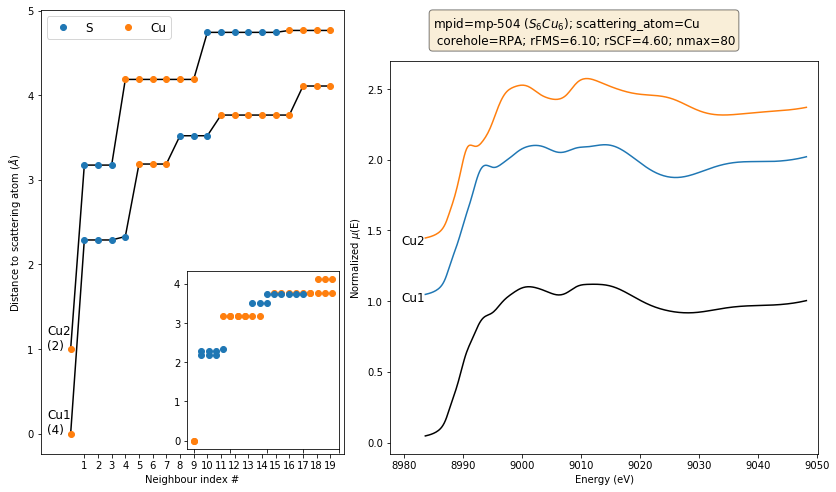

In [6]:
fig = plt.figure(figsize=(12,7))

gs1 = gridspec.GridSpec(1, 2, width_ratios=[2,3] )
gs1.update(top=0.95, bottom=0.07, left=0.07, right=0.97, wspace=0.05, hspace=0.05)

gs2 = gridspec.GridSpec(1, 2, width_ratios=[2,3] )
gs2.update(top=0.85, bottom=0.07, left=0.02, right=0.97, wspace=0.3, hspace=0.05)


ax=fig.add_subplot(gs1[0])
inset_ax = inset_axes(ax, width="50%", height="40%", loc=4)

s=0
for i in atoms_calculated:   
    ds = np.array(i[0])
    ax.plot(ds[0:20,0]+s,'k-')    
    for i,d in enumerate(ds):
        if i < 20: ax.plot( i, d[0]+s, 'oC'+str(int(d[1])) )   
        if i < 20: inset_ax.plot( i, d[0], 'oC'+str(int(d[1])) )   
    s += 1 
    
plt.xticks(visible=False)
        
for i in atoms_calculated[0][1]:
    ax.plot(19,0,'o',label=i)
    
s = 0          
for i in range(len(atoms_calculated)):
    ax.annotate(ca+str(i+1)+'\n('+str(occ_list[i])+')',(-1.7,s), fontsize=12)
    s += 1    
    
ax.legend(loc='upper left',fontsize=12,ncol=5) 
ax.set_xticks(range(1,20))

ax.set_xlim([-2.2,20])  
ax.set_xlabel('Neighbour index #')
ax.set_ylabel('Distance to scattering atom ($\AA$)')    
    

       
ax=fig.add_subplot(gs2[1])
ax.plot(e_int,xmu_total,'k-')
s=1
for i in xmus_calculated_int:
    ax.plot(i[0],s+i[1],'-')
    s = s + 0.4 
    
s = 1          
for i in range(len(atoms_calculated)):
    ax.annotate(ca+str(i+1),(e_int[0]-4,s), fontsize=12)
    s += 0.4     
# ax.annotate('w-ave',(e_int[0]-4,0.1), fontsize=12)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Normalized $\mu$(E)')     
ax.set_xlim([e_int[0]-6,e_int[-1]+2])  

textstr = 'mpid=%s (%s); scattering_atom=%s \n corehole=%s; rFMS=%.2f; rSCF=%.2f; nmax=%d'%(mpid, formula, ca, corehole, rFMS, rSCF, nmax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
ax.text(0.10, 1.12, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    
savefig('feff.png', format='png', dpi=300)    

<span class="mark">This part does cleaning</span>

In [7]:
folders = [f for f in os.listdir() if os.path.isdir(f)]
os.makedirs('feff',exist_ok=True)
for f in folders:
    if f[0:3] == 'at-': shutil.move(f, 'feff')
    
np.save('./feff/_xmus_calculated', xmus_calculated)    
np.save('./feff/_xmus_calculated_int', xmus_calculated_int)      
np.save('./feff/_atoms_calculated', atoms_calculated) 
np.save('./feff/_e_int', e_int) 
np.save('./feff/_xmu_total', xmu_total) 
np.save('./feff/_all_list', all_list) 

shutil.make_archive('feff', 'zip', 'feff')
# shutil.move('feff.zip', 'feff.npz')

shutil.rmtree('feff', ignore_errors=True)

os.chdir('..')